In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
df = pd.read_csv("data_rev_comma_separated.csv")
avg_income_df = pd.read_csv("avg_income.csv")

In [3]:
# merge with avg_income

df = df.merge(avg_income_df[['stateabbrev','AverageIncomePerCapita2022']], left_on='addr_state',right_on='stateabbrev', how='left')
df = df.drop(columns=['stateabbrev'])

# rename 'AverageIncomePerCapita2022' to avg_income
df = df.rename(columns={'AverageIncomePerCapita2022':'state_avg_inc'})

# 1. Data Understanding

In [4]:
df.sample(5)

,id,member_id,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,zip_code,addr_state,total_pymnt,total_rec_int,default_ind,state_avg_inc
285876,29193692,31726864,6000,36 months,12.49,10+ years,OWN,25000.0,debt_consolidation,562xx,MN,3010.5,778.63,0,68010.0
117176,5935285,7407420,8000,36 months,15.22,4 years,MORTGAGE,30000.0,debt_consolidation,313xx,GA,8339.96,1941.03,0,57129.0
279946,29854753,32387918,12575,36 months,6.03,10+ years,MORTGAGE,80000.0,debt_consolidation,193xx,PA,5736.74,771.31,0,65167.0
836993,39449538,42253264,8100,36 months,12.99,5 years,RENT,41000.0,debt_consolidation,331xx,FL,3260.07,900.37,0,63597.0
177358,2215923,2628183,18000,60 months,20.49,10+ years,MORTGAGE,55000.0,credit_card,778xx,TX,2.645.887.674,8458.88,0,61985.0


In [5]:
df.shape

(855969, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 855969 entries, 0 to 855968
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              855969 non-null  int64  
 1   member_id       855969 non-null  int64  
 2   loan_amnt       855969 non-null  int64  
 3   term            855969 non-null  object 
 4   int_rate        855969 non-null  float64
 5   emp_length      812908 non-null  object 
 6   home_ownership  855969 non-null  object 
 7   annual_inc      855969 non-null  float64
 8   purpose         855969 non-null  object 
 9   zip_code        855969 non-null  object 
 10  addr_state      855969 non-null  object 
 11  total_pymnt     855969 non-null  object 
 12  total_rec_int   855969 non-null  float64
 13  default_ind     855969 non-null  int64  
 14  state_avg_inc   853587 non-null  float64
dtypes: float64(4), int64(4), object(7)
memory usage: 104.5+ MB


# 2. Data Preparation

In [7]:
# Convert total_pymnt string to total_payment float
df['total_payment'] = df['total_pymnt'].str.replace('.','', regex=False).astype(float)

# Convert term string to term_nums float
df['term_nums'] = df['term'].str.replace(' months','', regex=False).astype(float)

# Convert emp_length from object to float
def convert_emp_length(value):
    if pd.isna(value):
        return np.nan
    if '<' in value:
        return 0
    if '10+' in value:
        return 10
    else:
        return int(value.split()[0])
    
df['emp_length_nums'] = df['emp_length'].apply(convert_emp_length)

In [8]:
df.shape

(855969, 18)

In [33]:
cats = ['home_ownership','purpose','default_ind']
nums = ['loan_amnt','term_nums','int_rate','emp_length_nums','annual_inc','total_payment','total_rec_int']
geo = ['zip_code','addr_state']

In [34]:
df.isna().sum()

id                     0
member_id              0
loan_amnt              0
term                   0
int_rate               0
emp_length         43061
home_ownership         0
annual_inc             0
purpose                0
zip_code               0
addr_state             0
total_pymnt            0
total_rec_int          0
default_ind            0
state_avg_inc       2382
total_payment          0
term_nums              0
emp_length_nums    43061
dtype: int64

In [35]:
print((43061/df.shape[0])*100)

5.030672839787422


Ada sejumlah 43061 value null dalam emp_length_nums. Missing value sejumlah 5 persen dari keseluruhan data, karena total data juga lebih dari 5000 rows maka row dengan nilai null dapat dihapus.

### Duplicate Values

In [36]:
# Duplicate values
duplicates = df.loc[df.duplicated()]

if not duplicates.empty:
    print(duplicates)
else:
    print("There is no duplicate values in this dataset")

There is no duplicate values in this dataset


# 3. Feature Understanding

## Univariate Analysis


In [37]:
df[nums].describe()

,loan_amnt,term_nums,int_rate,emp_length_nums,annual_inc,total_payment,total_rec_int
count,855969.000000,855969.000000,855969.000000,812908.000000,8.559690e+05,8.559690e+05,855969.000000
mean,14745.571335,43.170764,13.192320,6.019334,7.507119e+04,3.040335e+08,1755.046221
std,8425.340005,10.985382,4.368365,3.663588,6.426447e+04,1.217892e+09,2081.692980
min,500.000000,36.000000,5.320000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,8000.000000,36.000000,9.990000,3.000000,4.500000e+04,1.262240e+05,451.270000
50%,13000.000000,36.000000,12.990000,6.000000,6.500000e+04,4.042350e+05,1076.910000
75%,20000.000000,60.000000,15.990000,10.000000,9.000000e+04,1.111748e+06,2233.980000
max,35000.000000,60.000000,28.990000,10.000000,9.500000e+06,9.999728e+09,24205.620000


## Numericals

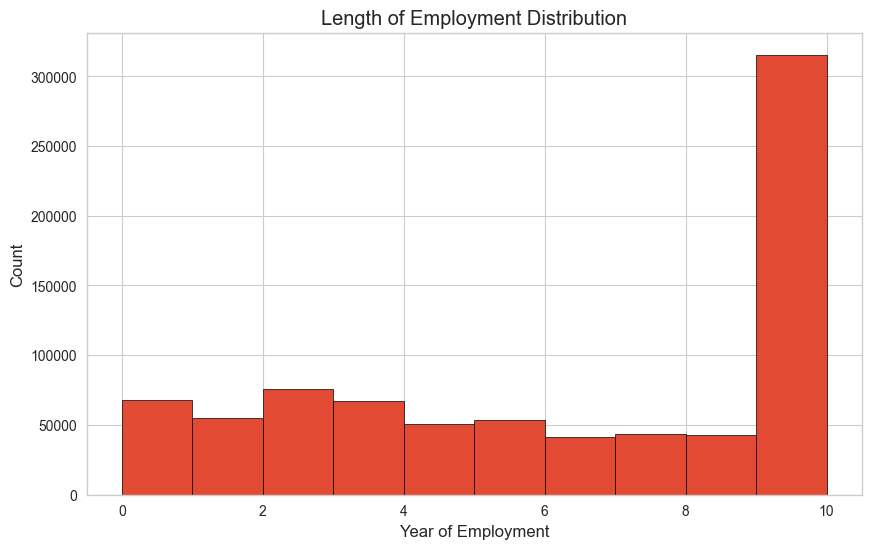

In [38]:
plt.figure(figsize=(10, 6))
plt.hist(df['emp_length_nums'], bins=10, edgecolor='black')
plt.title('Length of Employment Distribution')
plt.xlabel('Year of Employment')
plt.ylabel('Count')
plt.show()

c:\Users\rizar\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\rizar\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\rizar\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\rizar\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
c:\Users\rizar\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:159

<function matplotlib.pyplot.show(close=None, block=None)>

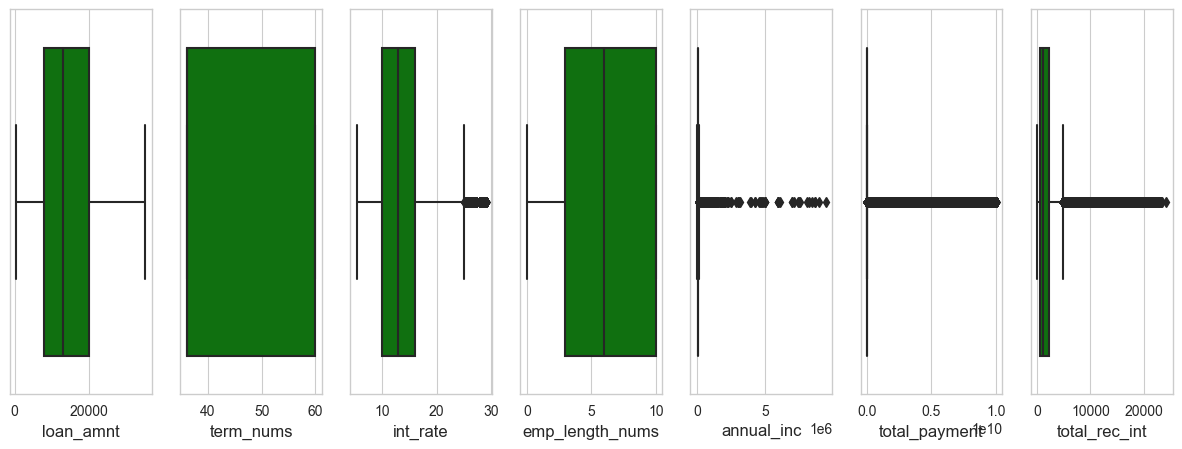

In [39]:
# Numericals Boxplot
plt.figure(figsize=(15,5))

for i in range(0, len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.boxplot(x=df[nums[i]], color='green', orient='v')
    plt.xlabel(nums[i])
    
plt.tight_layout
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

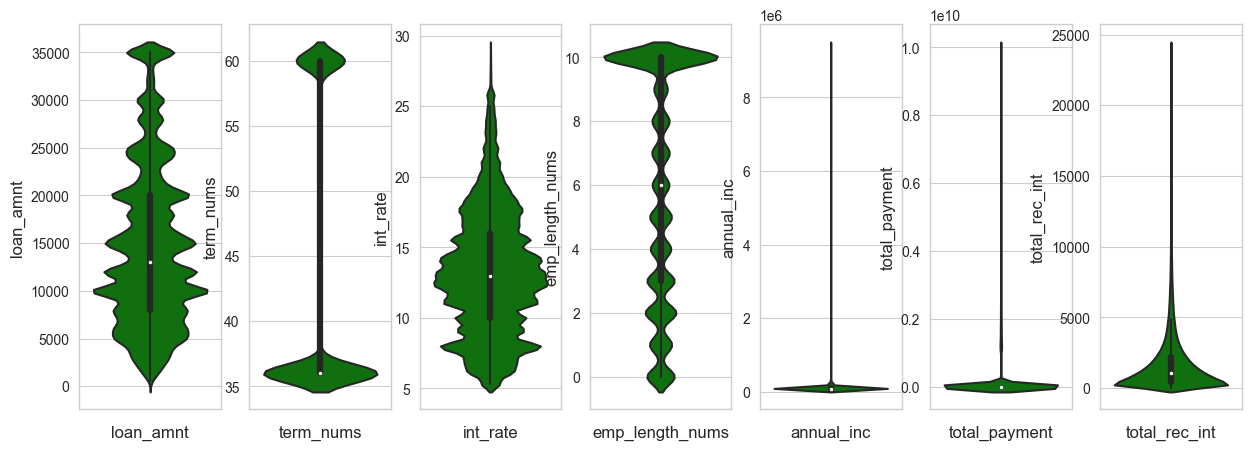

In [40]:
# Numericals Violinplot
plt.figure(figsize=(15,5))

for i in range(0, len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.violinplot(y=df[nums[i]], color='green', orient='v')
    plt.xlabel(nums[i])
    
plt.tight_layout
plt.show

C:\Users\rizar\AppData\Local\Temp\ipykernel_14804\515954374.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[nums[i]], color='blue', shade=True)
C:\Users\rizar\AppData\Local\Temp\ipykernel_14804\515954374.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[nums[i]], color='blue', shade=True)
C:\Users\rizar\AppData\Local\Temp\ipykernel_14804\515954374.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[nums[i]], color='blue', shade=True)
C:\Users\rizar\AppData\Local\Temp\ipykernel_14804\515954374.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error

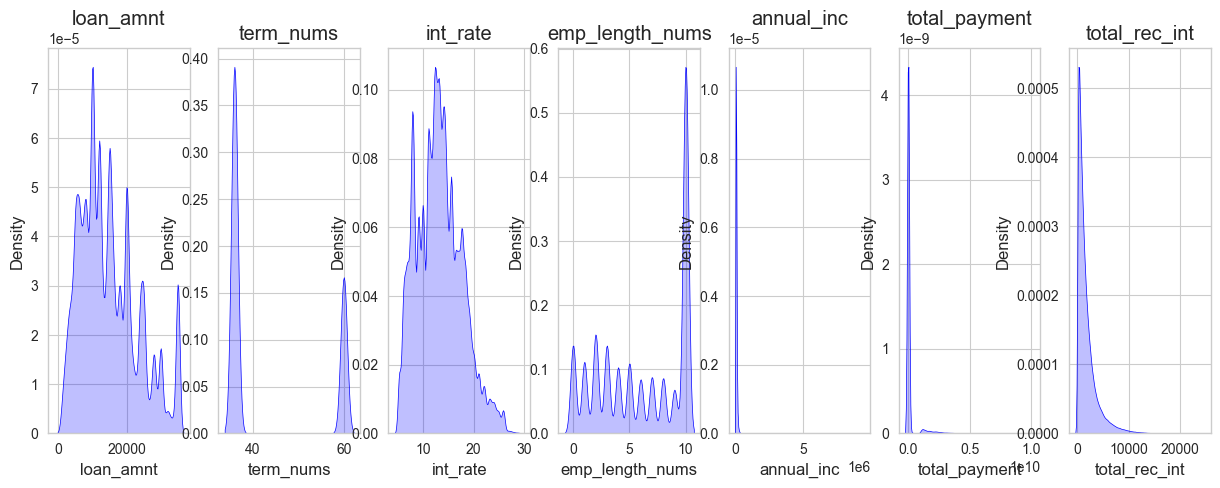

In [41]:
# Numericals KDE Plot
plt.figure(figsize=(15,5))

for i in range(0, len(nums)):
    plt.subplot(1, len(nums), i+1)
    sns.kdeplot(df[nums[i]], color='blue', shade=True)
    plt.title(nums[i])
    
    plt.tight_layout
    plt.show

## Geo

<function matplotlib.pyplot.show(close=None, block=None)>

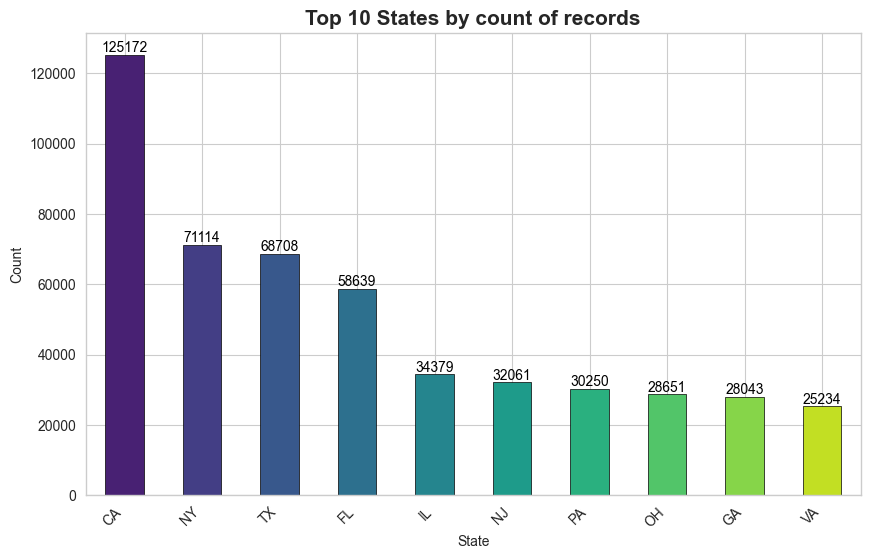

In [42]:
# Barplot for State

sns.set_style('whitegrid')
palette = sns.color_palette('viridis', 10)

plt.figure(figsize=(10,6))
ax = df['addr_state'].value_counts().head(10) \
    .plot(kind= 'bar', color= palette, edgecolor='black')

ax.set_title('Top 10 States by count of records', fontsize= 15, fontweight='bold')
ax.set_xlabel('State', fontsize=10)
ax.set_ylabel('Count', fontsize= 10)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Display values on top of each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height()}", 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='center', 
        xytext=(0, 5), textcoords='offset points', 
        fontsize=10, color='black'
    )
    
plt.tight_layout
plt.show

In [43]:
df['zip_code'].value_counts().head(10)

945xx    9466
750xx    9111
112xx    8894
606xx    8370
300xx    7820
100xx    7348
070xx    7143
331xx    7139
900xx    7022
770xx    6657
Name: zip_code, dtype: int64

## Categoricals

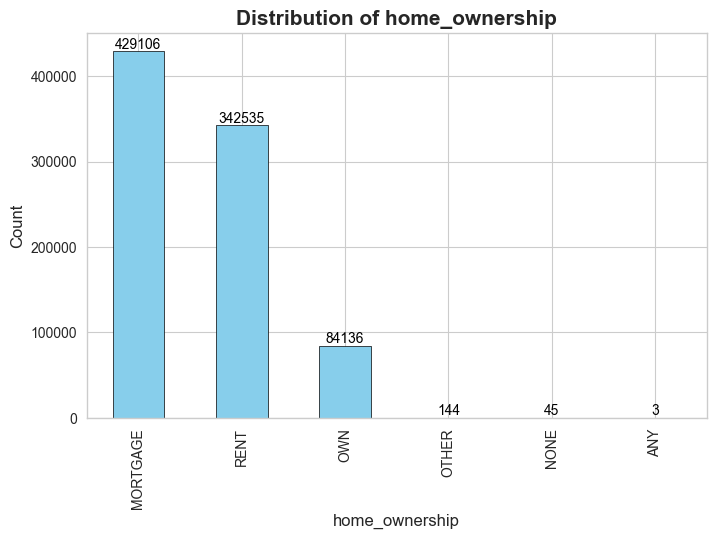

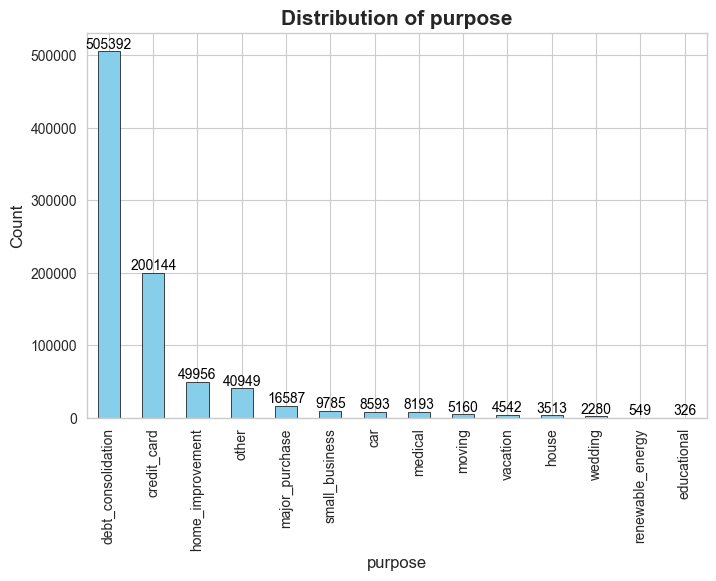

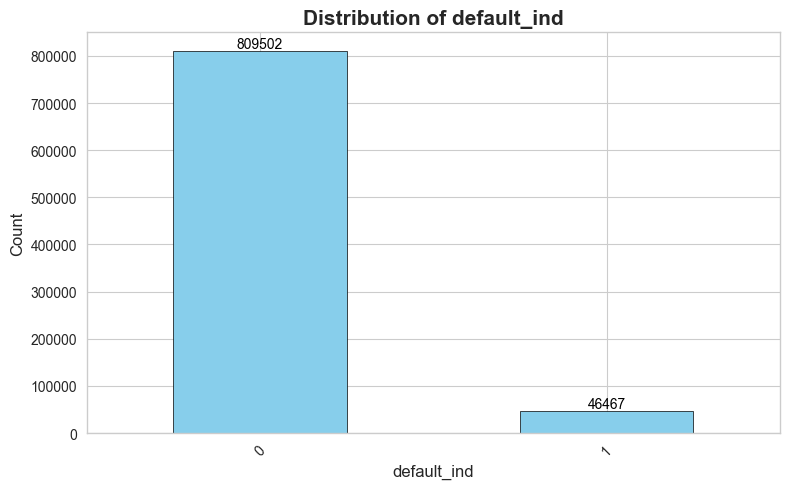

In [44]:
# Categorical values distribution

sns.set_style('whitegrid')

for cat in cats:
    plt.figure(figsize=(8,5))
    ax = df[cat].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

    ax.set_title(f'Distribution of {cat}', fontsize=15, fontweight='bold')
    ax.set_xlabel(cat, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)

# Display values on top of each bar
    for p in ax.patches:
        ax.annotate(f"{p.get_height()}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), textcoords='offset points', 
                    fontsize=10, color='black')
        
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

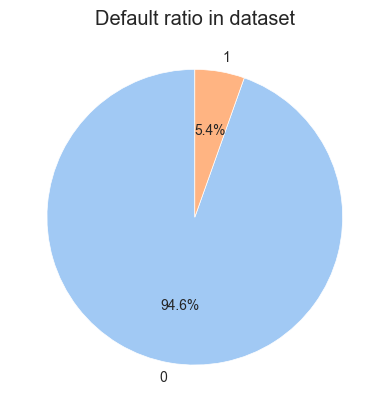

In [45]:
# Default Percentage represented in pie chart

df['default_ind'].value_counts().plot(kind='pie', autopct= '%1.1f%%', startangle=90, colors= sns.color_palette('pastel'))
plt.title('Default ratio in dataset')
plt.ylabel('')
plt.show()

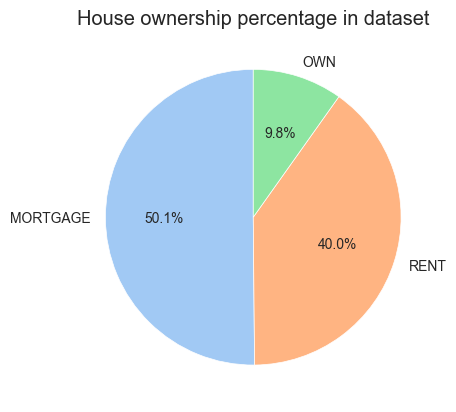

In [46]:
# House ownership status Percentage represented in pie chart

df['home_ownership'].value_counts().head(3).plot(kind='pie', autopct= '%1.1f%%', startangle=90, colors= sns.color_palette('pastel'))
plt.title('House ownership percentage in dataset')
plt.ylabel('')
plt.show()

# 4. Feature Relationships

### Pairplot

In [47]:
#sns.pairplot(df, vars=nums)
#plt.show()

### Correlation Heatmap

C:\Users\rizar\AppData\Local\Temp\ipykernel_14804\1727787355.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.dropna().corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)


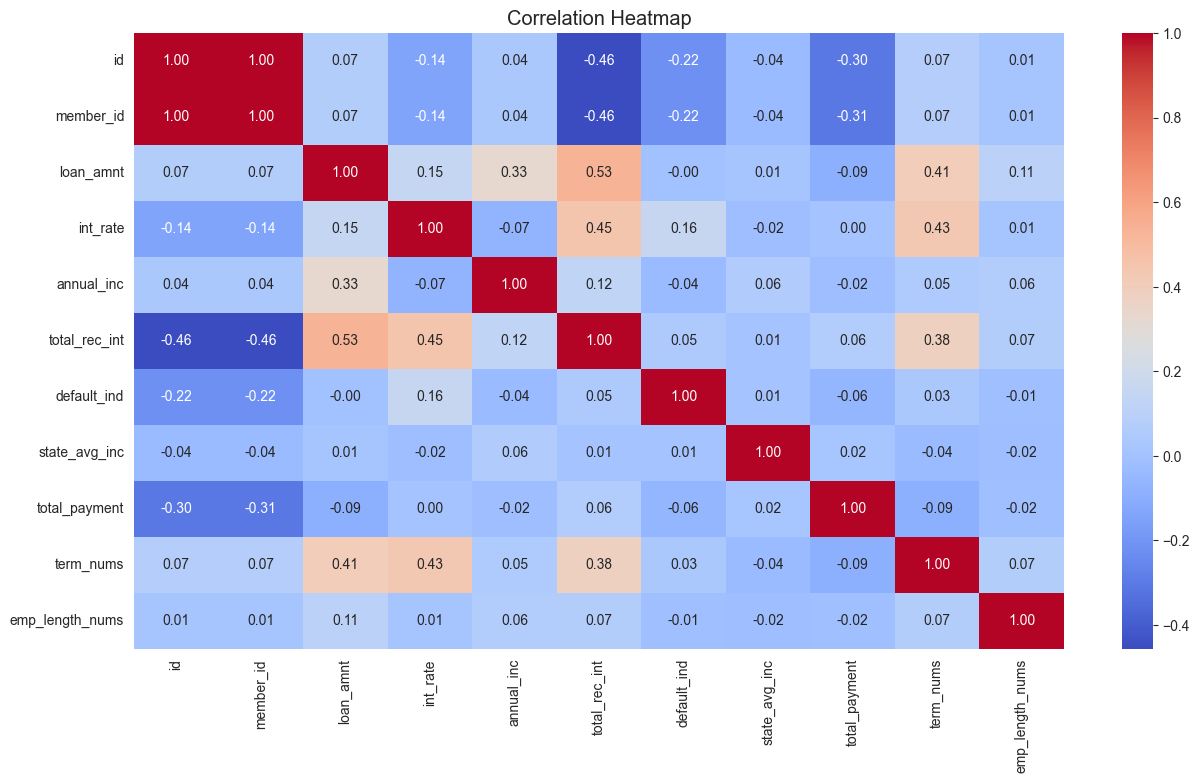

In [48]:
plt.figure(figsize=(15,8))
sns.heatmap(df.dropna().corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# 5. Data Cleansing

a. Outliers

Karena Objective dari projek ini adalah untuk memprediksi maka outliers akan kita remove dari dataset. Outlier ditentukan menggunakan Interquartile range dan diplot selanjutnya menggunakan Histogram KDE plot

In [49]:
df_cleaned = df.copy()

In [50]:
total_outliers_removed = 0

# Outlier del function
for col in nums:
    for i in range(2): 
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Hitung jumlah data sebelum penyaringan
        before_removal = df_cleaned.shape[0]
        # Saring data
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
        # Hitung jumlah data setelah penyaringan dan outlier yang dihapus
        after_removal = df_cleaned.shape[0]
        total_outliers_removed += (before_removal - after_removal)

print(f"Bentuk data setelah menghapus outlier: {df_cleaned.shape}")
print(f"Total outlier yang dihapus: {total_outliers_removed}")

Bentuk data setelah menghapus outlier: (571240, 18)
Total outlier yang dihapus: 284729


Jumlah data yang diolah untuk 'loan_amnt': 571240
Jumlah data yang diolah untuk 'term_nums': 571240
Jumlah data yang diolah untuk 'int_rate': 571240
Jumlah data yang diolah untuk 'emp_length_nums': 571240
Jumlah data yang diolah untuk 'annual_inc': 571240
Jumlah data yang diolah untuk 'total_payment': 571240
Jumlah data yang diolah untuk 'total_rec_int': 571240


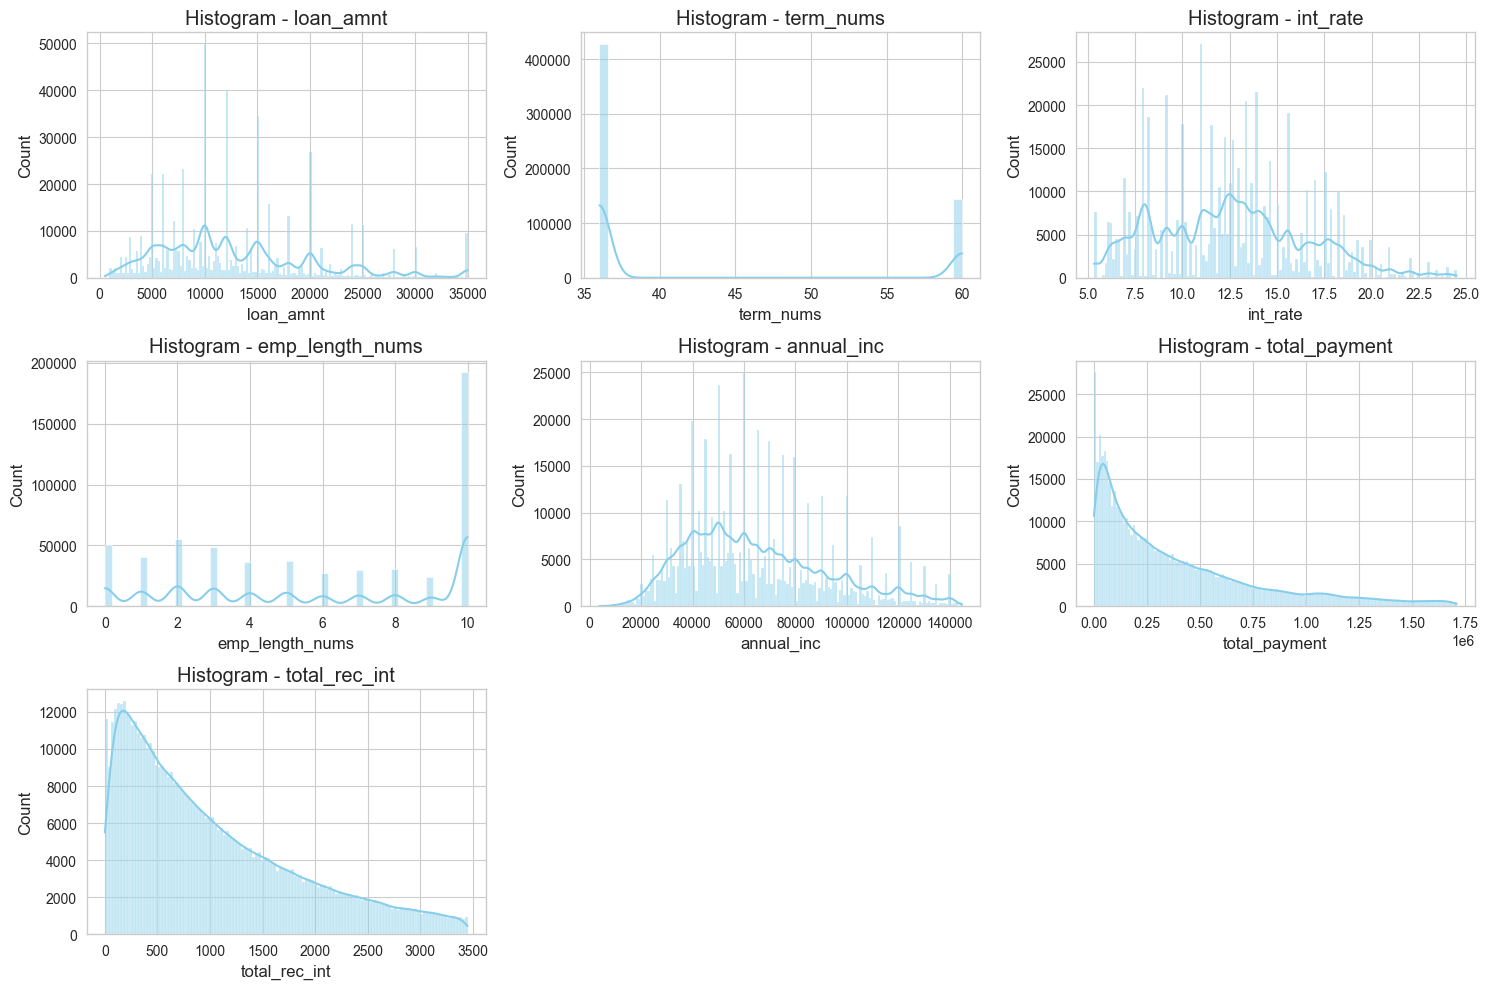

           loan_amnt      term_nums       int_rate  emp_length_nums  \
count  571240.000000  571240.000000  571240.000000    571240.000000   
mean    12790.459001      42.043484      12.556721         5.915536   
std      7256.098493      10.417299       3.958799         3.683954   
min       500.000000      36.000000       5.320000         0.000000   
25%      7500.000000      36.000000       9.170000         2.000000   
50%     11500.000000      36.000000      12.490000         6.000000   
75%     16175.000000      60.000000      14.990000        10.000000   
max     35000.000000      60.000000      24.500000        10.000000   

          annual_inc  total_payment  total_rec_int  
count  571240.000000   5.712400e+05  571240.000000  
mean    64792.640491   3.884844e+05    1022.914395  
std     27472.375533   3.847330e+05     834.133730  
min      3800.000000   0.000000e+00       0.000000  
25%     44000.000000   8.971400e+04     346.340000  
50%     60000.000000   2.598880e+05     79

In [51]:
for col in nums:
    print(f"Jumlah data yang diolah untuk '{col}': {len(df_cleaned[col].dropna())}")

# Histl=plot
plt.figure(figsize=(15, 10))  
for i, col in enumerate(nums, 1):
    plt.subplot(3, 3, i)  
    sns.histplot(df_cleaned[col], kde=True, color='skyblue')
    plt.title(f'Histogram - {col}')
    plt.xlabel(col)


if len(nums) < 9:  
    for j in range(len(nums) + 1, 10):  
        plt.subplot(3, 3, j).axis('off')  
plt.tight_layout()
plt.show()

# New Stats
print(df_cleaned[nums].describe())


b. Missing Values

In [52]:
df_cleaned = df_cleaned.dropna()

print("Shape before:", df.shape)
print("Shape after:", df_cleaned.shape)

Shape before: (855969, 18)
Shape after: (569709, 18)


# 6. Feature Engineering

In [53]:
# 1. Menambahkan kolom 'monthly_income' dari 'annual_inc'
df_cleaned['monthly_income'] = df_cleaned['annual_inc'] / 12

# 2. Melakukan encoding pada kolom 'home_ownership' dengan urutan Own > Rent > Mortgage
home_ownership_mapping = {'OWN': 3, 'RENT': 2, 'MORTGAGE': 1}
df_cleaned['home_ownership_encoded'] = df_cleaned['home_ownership'].map(home_ownership_mapping)

In [54]:
df_cleaned['income_to_loan'] = df_cleaned['monthly_income'] / df_cleaned['loan_amnt'] 
df_cleaned['income_to_loan_ratio_percentage'] = df_cleaned['income_to_loan'] * 100
print(df_cleaned['income_to_loan_ratio_percentage'])

1         100.000000
4         222.222222
6          55.957143
8          59.523810
9          23.255814
             ...    
855964     25.833333
855965     27.430556
855966     22.435897
855967     44.722222
855968     41.666667
Name: income_to_loan_ratio_percentage, Length: 569709, dtype: float64


In [55]:
df_cleaned['asset_to_loan_ratio'] = df_cleaned['income_to_loan'] + df_cleaned['home_ownership_encoded']
def evaluate_risk(row):
    if row['income_to_loan_ratio_percentage'] > 20 and row['home_ownership_encoded'] >= 1:
        return 'Aman'
    else:
        return 'Risiko'

df_cleaned['risk_status'] = df_cleaned.apply(evaluate_risk, axis=1)

# 3. Mencetak hasil dengan status risiko
print(df_cleaned[['monthly_income', 'home_ownership_encoded', 'income_to_loan_ratio_percentage', 'risk_status']])

        monthly_income  home_ownership_encoded  \
1          2500.000000                     2.0   
4          6666.666667                     2.0   
6          3917.000000                     2.0   
8          3333.333333                     3.0   
9          1250.000000                     2.0   
...                ...                     ...   
855964     2583.333333                     2.0   
855965     6583.333333                     1.0   
855966     2916.666667                     2.0   
855967     5366.666667                     2.0   
855968     8333.333333                     2.0   

        income_to_loan_ratio_percentage risk_status  
1                            100.000000        Aman  
4                            222.222222        Aman  
6                             55.957143        Aman  
8                             59.523810        Aman  
9                             23.255814        Aman  
...                                 ...         ...  
855964               

In [56]:
def categorize_risk(row):
    if row['income_to_loan_ratio_percentage'] > 20 and row['home_ownership_encoded'] >= 1:
        if row['asset_to_loan_ratio'] > 3:
            return 'No Risk'
        elif 2 <= row['asset_to_loan_ratio'] <= 3:
            return 'Low Risk'
        else:
            return 'Medium Risk'
    else:
        return 'High Risk'

# 3. Menambahkan kolom risk_category ke DataFrame
df_cleaned['risk_category'] = df_cleaned.apply(categorize_risk, axis=1)

# 4. Mencetak hasil dengan status risiko
print(df_cleaned[['monthly_income', 'home_ownership_encoded', 'income_to_loan_ratio_percentage', 'asset_to_loan_ratio', 'risk_category']])

        monthly_income  home_ownership_encoded  \
1          2500.000000                     2.0   
4          6666.666667                     2.0   
6          3917.000000                     2.0   
8          3333.333333                     3.0   
9          1250.000000                     2.0   
...                ...                     ...   
855964     2583.333333                     2.0   
855965     6583.333333                     1.0   
855966     2916.666667                     2.0   
855967     5366.666667                     2.0   
855968     8333.333333                     2.0   

        income_to_loan_ratio_percentage  asset_to_loan_ratio risk_category  
1                            100.000000             3.000000      Low Risk  
4                            222.222222             4.222222       No Risk  
6                             55.957143             2.559571      Low Risk  
8                             59.523810             3.595238       No Risk  
9             

In [57]:
from sklearn.preprocessing import StandardScaler

# Inisialisasi StandardScaler
scaler = StandardScaler()

# 1. Standarisasi Kolom 'loan_amnt' dan 'total_rec_int'
df_cleaned[['loan_amnt', 'total_rec_int']] = scaler.fit_transform(df_cleaned[['loan_amnt', 'total_rec_int']])

In [58]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569709 entries, 1 to 855968
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   id                               569709 non-null  int64  
 1   member_id                        569709 non-null  int64  
 2   loan_amnt                        569709 non-null  float64
 3   term                             569709 non-null  object 
 4   int_rate                         569709 non-null  float64
 5   emp_length                       569709 non-null  object 
 6   home_ownership                   569709 non-null  object 
 7   annual_inc                       569709 non-null  float64
 8   purpose                          569709 non-null  object 
 9   zip_code                         569709 non-null  object 
 10  addr_state                       569709 non-null  object 
 11  total_pymnt                      569709 non-null  object 
 12  to

In [59]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

#Encode risk_category
risk_category_mapping = {'High Risk':4, 'Medium Risk': 3, 'Low Risk': 2, 'No Risk': 1}
df_cleaned['risk_category_cat'] = df_cleaned['risk_category'].map(risk_category_mapping)

#Apply label encode to risk_status
labelencoder = LabelEncoder()
df_cleaned['risk_status_cat'] = labelencoder.fit_transform(df_cleaned['risk_status'])

In [60]:
df_cleaned['risk_category_cat']

1         2
4         1
6         2
8         1
9         2
         ..
855964    2
855965    3
855966    2
855967    2
855968    2
Name: risk_category_cat, Length: 569709, dtype: int64